<a href="https://colab.research.google.com/github/lgiesen/forest_height/blob/main/boosted_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount ('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# the zipped data is uploaded in the root_path folder
root_path = 'drive/MyDrive/Colab Notebooks/data/'
path_images = f'{root_path}images/'
path_masks = f'{root_path}masks/'
user = "lgiesen"
repo = "forest_height"
!git clone https://github.com/{user}/{repo}.git

Cloning into 'forest_height'...
remote: Enumerating objects: 511, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 511 (delta 84), reused 66 (delta 19), pack-reused 348
Receiving objects: 100% (511/511), 23.61 MiB | 6.86 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [ ]:
%run /content/forest_height/src/load_data.py
%run /content/forest_height/src/evaluate_model.py

Fit Models on Color Channels and NDVI

In [ ]:
X_train, y_train, X_test, y_test = load_data("color_channels_ndvi")

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
# initialize model
gbr = GradientBoostingRegressor(n_estimators = 150, max_depth= 1, random_state=42)
# train model
gbr.fit(X_train, y_train)
# predict test set
y_pred = gbr.predict(X_test)
# evaluate model
mae_color_channels_ndvi, mse_color_channels_ndvi, rmse_color_channels_ndvi, mape_color_channels_ndvi = evaluate_model(y_test, y_pred)

MAE: 10.092877021160097; MSE: 137.75650950956222; RMSE: 3.176928866241751; MAPE: 1.305910827688001


Save model with all features

In [ ]:
import joblib
%cd forest_height/models
# save model
joblib.dump(gbr, f'boosted_trees_color_channels_NDVI_{round(mae_color_channels_ndvi,2)}.joblib')
%cd ../../
# load model with:
# gbr_color_channels_NDVI = joblib.load("forest_height/models/boosted_trees__color_channels_NDVI_10.09.joblib")

/content/forest_height/models
/content


Feature: 0, Score: 0.08261
Feature: 1, Score: 0.09323
Feature: 2, Score: 0.08074
Feature: 3, Score: 0.02261
Feature: 4, Score: 0.04095
Feature: 5, Score: 0.04093
Feature: 6, Score: 0.09397
Feature: 7, Score: 0.00702
Feature: 8, Score: 0.03460
Feature: 9, Score: 0.05083
Feature: 10, Score: 0.45251


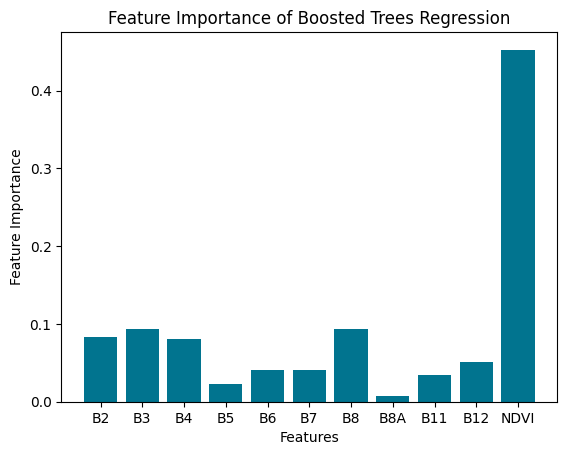

In [ ]:
import matplotlib.pyplot as plt
# get importance
# importance = rf_random.coef_
importance = gbr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI'], importance, color="#01748F")
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Feature Importance of Boosted Trees Regression")
plt.show()

Fit Model on Color Channels

In [ ]:
X_train, y_train, X_test, y_test = load_data("color_channels")
# train model
gbr.fit(X_train, y_train)
# predict test set
y_pred = gbr.predict(X_test)
# evaluate model
mae_color_channels, mse_color_channels, rmse_color_channels, mape_color_channels = evaluate_model(y_test, y_pred)

MAE: 10.021331480015412; MSE: 135.55796021151036; RMSE: 3.1656486665477286; MAPE: 1.272418144636603


Fit Model on NDVI

In [ ]:
X_train, y_train, X_test, y_test = load_data("ndvi")
# reshape to fit model
X_train, X_test = X_train.reshape(-1,1), X_test.reshape(-1,1)
# train model
gbr.fit(X_train, y_train)
# predict test set
y_pred = gbr.predict(X_test)
# evaluate model
mae_ndvi, mse_cndvi, rmse_ndvi, mape_ndvi = evaluate_model(y_test, y_pred)

MAE: 10.010264086025932; MSE: 136.04751729766355; RMSE: 3.1639001384408347; MAPE: 1.2606865889059502


Save NDVI model

In [ ]:
import joblib
%cd forest_height/models
# save model
joblib.dump(gbr, f'boosted_trees_NDVI_{round(mae_color_channels_ndvi,2)}.joblib')
%cd ../../
# load model with:
# gbr = joblib.load("forest_height/models/boosted_trees_NDVI_10.01.joblib.joblib")

['boosted_trees10.01.joblib']

Predictions vs True Values

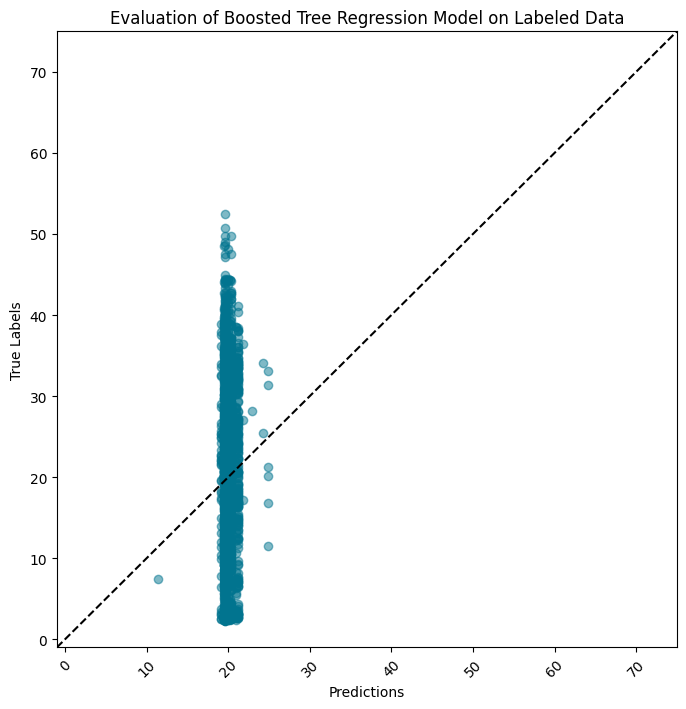

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# visualize predictions vs. true labels
fig = plt.figure(figsize=(8,8))
plt.scatter(y_pred, y_test, color="#01748F", alpha=0.5)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.plot([-1,75], [-1, 75], 'k--')
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.xlim([-1,75])
plt.ylim([-1,75])
plt.title("Evaluation of Boosted Tree Regression Model on Labeled Data")
plt.show()

The random boosted trees regression is simply the average dataset tree height of ~18m. It performs poorly for lower and higher tree heights and is unable to predict tree heights, which deviate from the mean.

Visualize model predictions vs. true values

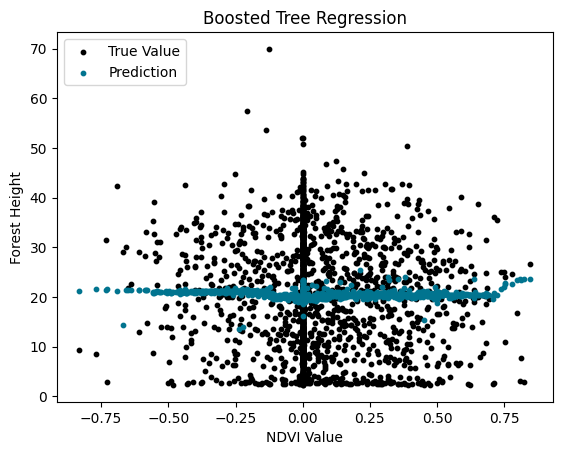

In [ ]:
from matplotlib import pyplot as plt
# only the NDVI channel is plotted on the x-axis
# because 11-dimensional data cannot be visualized for humans
fig, ax = plt.subplots()
plt.scatter(X_test[:,10], y_test, 10, color = 'black')
plt.scatter(X_test[:,10], y_pred, 10, color = '#01748F')
plt.title('Boosted Tree Regression')
plt.xlabel('NDVI Value')
plt.ylabel('Forest Height')
ax.legend(("True Value", "Prediction"), loc='upper left')
plt.show()